##### Copyright 2018 The TensorFlow Authors.

In [3]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [4]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [5]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

history of a model - a bunch of metrics like training loss over time, training validation over time, etc. 

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [6]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [32]:
# from the training set, take 1 example - default data type is a tensor (fancy numpy array) which is why numpy is used a lot 
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  [b'Coonskin might be my favorite Ralph Bakshi film. Like the best of his work, it\'s in-your-face and not ashamed of it for a second, but unlike some of his other work (even when he\'s at his finest, which was before and after Coonskin with Heavy Traffic and Wizards), it\'s not much uneven, despite appearances to the contrary. Bakshi\'s taking on stereotypes and perceptions of race, of course, but moreover he\'s making what appears to be a freewheeling exploitation film; blaxploitation almost, though Bakshi doesn\'t stop just there. If it were just a blaxploitation flick with inventive animation it could be enough for a substantial feature. But Bakshi\'s aims are higher: throwing up these grotesque and exaggerated images of not just black people but Italians/mafioso, homosexuals, Jews, overall New York-types in the urban quarters of Manhattan in the 70s, he isn\'t out to make anything realistic. The most normal looking creation in looking drawn "real" is, in fact, a naked woman 

Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [8]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64 

batch size - number of training examples utiltized in one interation, ex. take the first 64 and trains the model, then the next 64, and so on until the whole 
Buffer size - how much you take out from the total dataset
epochs - how many times it updates the model 
Check out here  https://datascience.stackexchange.com/questions/89316/tensorflows-shufflebuffer-size

We have 25,000 training examples but we don't want to train on the whole data set. A buffer size of 10,000 using for training. Take a sample of 64 or batch, over and over until we reach the buffer size. 

When we do this, something that can scale and work more efficiently. If we have half a billion tweets for example, to shuffle up and draw from it, it takes less time to do this from a smaller buffer size. Working with a small subset of the data (buffer) run on the batch and update the weights based on that after 64 examples. Update every batch size and not after each example because otherwise it can be more skewed. Example of 10 cards, 6 dogs and 4 cats, if first 6 are dogs, will assume dog is next but it's inaccurate. 

Model learns from a batch of data and minimizes overfitting. 

In [9]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

prefetch - we don't need this, tells computer how much CPU to use, optimization thing 

In [10]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"And so the great rewriting of history continues Hollywood style.<br /><br />This was senseless ridiculous rubbish.<br /><br />Its shocks me that such an amazing amount of money can be spent to produce what is the most contrived, poorly acted inaccurate film I have ever seen. It is appalling.<br /><br />Nic Cage's brief flirtation with serious acting appears to be over. I can only assume that Leaving Las Vegas was a glitch in an otherwise litany of dreadful films.<br /><br />Diane Kruger proves that her performance in Troy was no fluke, she really can't act.<br /><br />Harvey Keitel should be ashamed of himself for working on such tripe.<br /><br />Only recommended for those either recovering from a recent lobotomy or people of an opinion that America invented the world."
 b"This is an abysmal piece of story-telling. It is about an hour into the movie before we have much idea of what it is supposed to be about; the characters often mumble inaudibly; actions frequently seem to

Notice that the data isn't super clean...html in there.

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [11]:
VOCAB_SIZE = 1000 # 1000 more frequent words 
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Reduce document size - document vectorization, and converting it to numerical representation. Every document will be a sequence of numbers (of 1000 in this case) 

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [12]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [13]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 3, 38,  2, ...,  0,  0,  0],
       [11,  7, 34, ...,  0,  0,  0],
       [11, 74,  1, ...,  0,  0,  0]])

Each number represents a word in the vocabulary. Numerical representation of the document from the vocabulary 

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [14]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"And so the great rewriting of history continues Hollywood style.<br /><br />This was senseless ridiculous rubbish.<br /><br />Its shocks me that such an amazing amount of money can be spent to produce what is the most contrived, poorly acted inaccurate film I have ever seen. It is appalling.<br /><br />Nic Cage's brief flirtation with serious acting appears to be over. I can only assume that Leaving Las Vegas was a glitch in an otherwise litany of dreadful films.<br /><br />Diane Kruger proves that her performance in Troy was no fluke, she really can't act.<br /><br />Harvey Keitel should be ashamed of himself for working on such tripe.<br /><br />Only recommended for those either recovering from a recent lobotomy or people of an opinion that America invented the world."
Round-trip:  and so the great [UNK] of history [UNK] hollywood [UNK] br this was [UNK] ridiculous [UNK] br its [UNK] me that such an amazing [UNK] of money can be [UNK] to [UNK] what is the most [UNK] poor

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


Every word, prior to go into the model is embedded. Can use pretrained embeddings, like word2vec. What goes into the model isn't the token itself but it's a numerical representation or word embedding. 

The code to implement this is below:

In [15]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding( # embedding layer
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), # bidirectional layer 
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1) # gives a score between 0-1
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [16]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [17]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 6s 6s/step
[-0.00107242]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [18]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 66ms/step
[-0.00107242]


Compile the Keras model to configure the training process:

In [19]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [20]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 49s 100ms/step - loss: 0.6630 - accuracy: 0.5514 - val_loss: 0.5732 - val_accuracy: 0.6677
Epoch 2/10
391/391 [==============================] - 26s 67ms/step - loss: 0.4596 - accuracy: 0.7699 - val_loss: 0.3978 - val_accuracy: 0.8052
Epoch 3/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3588 - accuracy: 0.8378 - val_loss: 0.3552 - val_accuracy: 0.8365
Epoch 4/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3310 - accuracy: 0.8534 - val_loss: 0.3408 - val_accuracy: 0.8365
Epoch 5/10
391/391 [==============================] - 31s 78ms/step - loss: 0.3154 - accuracy: 0.8628 - val_loss: 0.3285 - val_accuracy: 0.8490
Epoch 6/10
391/391 [==============================] - 28s 71ms/step - loss: 0.3089 - accuracy: 0.8668 - val_loss: 0.3254 - val_accuracy: 0.8568
Epoch 7/10
391/391 [==============================] - 27s 68ms/step - loss: 0.3065 - accuracy: 0.8676 - val_loss: 0.3289 - val_accuracy

In [21]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 31ms/step - loss: 0.3166 - accuracy: 0.8538
Test Loss: 0.3165911138057709
Test Accuracy: 0.8537999987602234


(0.0, 0.6812604099512101)

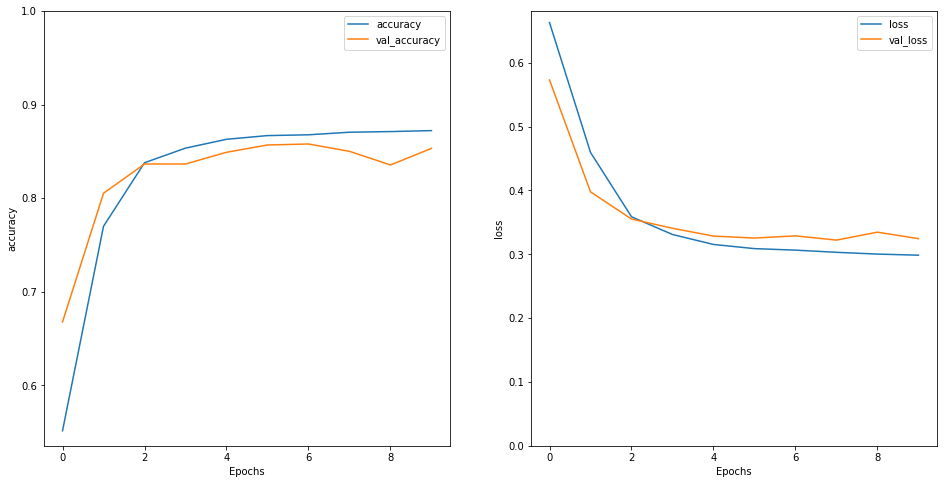

In [22]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Can it stopped learning around 4 epochs in both metrics. 

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [23]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


In [33]:
predictions

array([[-1.7561256]], dtype=float32)

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [24]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [25]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [26]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 78s 156ms/step - loss: 0.6297 - accuracy: 0.5921 - val_loss: 0.4524 - val_accuracy: 0.7974
Epoch 2/10
391/391 [==============================] - 50s 129ms/step - loss: 0.3943 - accuracy: 0.8273 - val_loss: 0.3520 - val_accuracy: 0.8500
Epoch 3/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3389 - accuracy: 0.8553 - val_loss: 0.3321 - val_accuracy: 0.8568
Epoch 4/10
391/391 [==============================] - 43s 110ms/step - loss: 0.3223 - accuracy: 0.8620 - val_loss: 0.3360 - val_accuracy: 0.8667
Epoch 5/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3164 - accuracy: 0.8654 - val_loss: 0.3259 - val_accuracy: 0.8615
Epoch 6/10
391/391 [==============================] - 50s 127ms/step - loss: 0.3072 - accuracy: 0.8700 - val_loss: 0.3165 - val_accuracy: 0.8547
Epoch 7/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3074 - accuracy: 0.8686 - val_loss: 0.3178 - val_ac

In [27]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 19s 48ms/step - loss: 0.3214 - accuracy: 0.8469
Test Loss: 0.3214079737663269
Test Accuracy: 0.8468800187110901


In [28]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-1.7561256]]


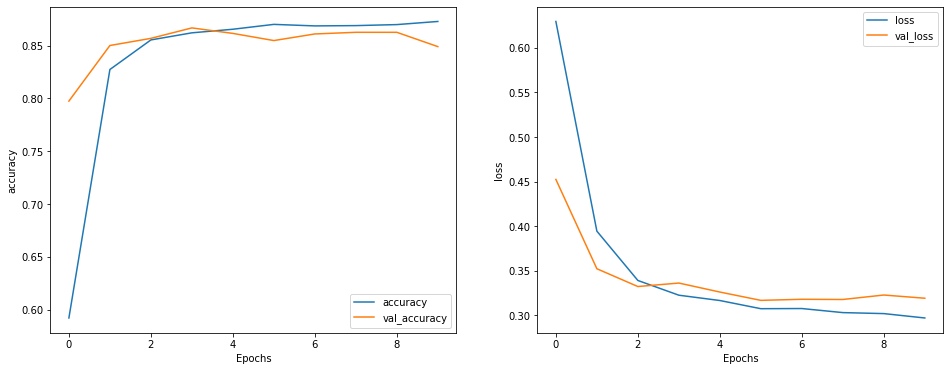

In [29]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
